# 准备

## 环境

In [1]:
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
# plt.style.use('seaborn-poster')
plt.style.use('seaborn-dark')
plt.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体,用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #解决保存图像是负号'-'显示为方块的问题

## 符号

In [2]:
import sympy as sp
a,b,c,d,x, y, z, t = sp.symbols('a b c d x y z t')
k, m, n = sp.symbols('k m n', integer=True)
f, g, h = sp.symbols('f g h', cls=sp.Function)
sp.init_printing()
# common tool function
def getM(var_name,r,c):
    """
    make a sympy s matrix
    :param var_name:the symbol name
    :param r:matrix s rows
    :param c:matrix s cols
    """
    if r>1 and c>1:
        ss=sp.symbols("{0}_{{{{0:{1}}}{{0:{2}}}}}".format(var_name,r,c))        
    elif r==1:
        ss=sp.symbols("{0}_{{0:{1}}}".format(var_name,c))
    elif c==1:
        ss=sp.symbols("{0}_{{0:{1}}}".format(var_name,r))
    else:
        raise Exception('invalid input parameter！')
    return sp.Matrix([ss[i*c:(i+1)*c] for i in range(r)])

In [78]:
def na(x:pd.DataFrame):
    assert x.isna().sum().sum()==0

## 无风险收益率和年交易日

In [3]:
YTD=250#trading days in one year
RFR=4e-2#risk free rate

## 模拟数据

In [4]:
s_n,s_t=4,20#的数、时序长
np.random.seed(0)
rs=pd.DataFrame(np.random.normal(loc=RFR,scale=2*RFR,size=(s_t,s_n,)))#t期的收益率

In [5]:
cov=rs.cov()#方差协方差矩阵
exr=rs.mean(axis=0)#期望收益以历史收益的期望代替
cov.shape,exr.shape

In [6]:
cov

,0,1,2,3
0,0.011113,0.000610,0.002297,0.000180
1,0.000610,0.005256,0.001100,0.000022
2,0.002297,0.001100,0.004235,-0.000610
3,0.000180,0.000022,-0.000610,0.005626


# 现代资产组合理论
[（Modern Portfolio Theory，简称MPT）](https://wiki.mbalib.com/wiki/%E6%8A%95%E8%B5%84%E7%BB%84%E5%90%88%E7%90%86%E8%AE%BA)

# 收益和风险
0. 预期数据
    1. 一般以历史统计值表征
    2. 其他方法估计
1. 标的
    1. 收益：$\mu=E(r)$$=\sum_sp(s)r(s)\\=\frac{\sum_{t=1}^{T}{r_t}}{T}$
    2. 风险：$\sigma=\sqrt D=\sqrt{\sum_sp(s)[r(s)-\mu]^2}\\=\frac{\sum_{t=1}^{T}{(r_t-\mu)}^2}{T}$
3. 组合
    1. 收益: $M=w^Tu$   
    2. 风险: $\Sigma=\sqrt{w^T{C}w}\leq w^T\sigma$
3. eg.两资产组合
    1. 收益：$E(R_p)=w_1E(R_1)+w_2E(R_2)$
    2. 风险：$\sigma_p$$=\sqrt{w^T{C}w}\\=\sqrt{w_1^2\sigma_1^2+w_2^2\sigma_2^2+2w_1w_2\sigma_1\sigma_2\rho_{12}}\qquad ,\rho=\frac{Cov(x,y)}{\sigma_x\sigma_y}\in [-1,1]\\\leq w_x \sigma_x+w_y\sigma_y$

# 组合风险推导
$\because D(R)=E[{(R-\bar R)}^2],\mu=E(R)=w^Tr$

$\therefore D(R)$$=E\left[{(w^Tr-w^T\bar r)}^2\right]\\
=E\left\{{\left[\sum_{i=1}^n{(w_i(r_i-\bar {r_i}))}\right]}^2\right\}\\
=E\left\{{\left[\sum_{i=1}^n\sum_{j=1}^n{(w_i(r_i-\bar {r_i})w_j(r_j-\bar {r_j}))}\right]}\right\}\\
=E\left\{{\left[\sum_{i=1}^n\sum_{j=1}^n{(w_iw_jcov(r_i,r_j))}\right]}\right\}\\
=w^TCw\\
$

# 可行集（蒙特卡洛）
1. 所有可能的充分投资组合风险收益集合（限制做空）

In [7]:
# 蒙特卡洛寻找有效边界
def _f(ws,er,cov):
    ws/=np.sum(ws)
    xret=np.dot(ws,er)
    xstd=np.sqrt(np.dot(np.dot(ws,cov),ws.T))    
    return xret,xstd,(xret-RFR)/xstd
mc=np.array([_f(np.random.random(size=exr.shape),exr,cov)for _ in range(10000)])

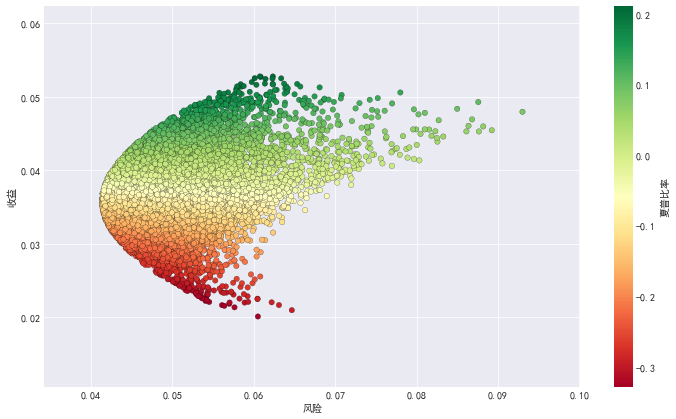

In [8]:
plt.figure(figsize=(12, 7))
plt.scatter(
    mc[:,1], mc[:,0], c=mc[:,2],cmap='RdYlGn', 
    edgecolors='black',marker='o',
    linewidth=0.2,s=30) 
plt.grid(True)
plt.xlabel('风险')
plt.ylabel('收益')
plt.colorbar(label='夏普比率')

**小结:**
1. 有效集：同等收益水平下风险最小，同等风险水平下收益最大
2. 如何求有效集-有效前沿

# 特征投资组合

## 投资组合的属性头寸
每种资产标的都具有多重属性（因子）。令$\alpha^T=\{\alpha_0,\dots,\alpha_n\}$表示资产的属性（特征或因子）的向量，那么投资组合在属性向量$\alpha$上的头寸（exposure）可简记为$\alpha_p=\alpha^Tw_p$,$w_p$:资产持有权重向量

## 对应数学问题
$minimize:\quad f(w)=w^TVw\\subject\ \ to:\begin{cases}\quad h(w)=a^Tw-1=0\end{cases}$

$V$:资产的方差协方差矩阵

## 小结
1. 在$V$和$\alpha$已知的情况下求满足约束条件下最小风险的$h$,对应凸优化方法

# 凸优化、拉格朗日乘子法和KKT条件
1. [凸优化、拉格朗日乘子法和KKT条件](https://zhuanlan.zhihu.com/p/59928816)
2. [如何理解拉格朗日乘子法？](https://www.matongxue.com/madocs/939.html)
3. [如何理解拉格朗日乘子法和KKT条件？](https://www.matongxue.com/madocs/987/)

# 特征投资组合引理

## 引理一:特征投资组合解
$w=\frac{V^{-1}a}{a^TV^{-1}a}$

**证明：**
1. 凸优化问题：$minimize:\quad f(w)=w^TVw\\subject\ \ to:\begin{cases}\quad h(w)=a^Tw-1=0\end{cases}$
2. 拉格朗日乘子：$L=f(w)-\lambda h(w)$ 
3. KKT条件：$\begin{cases}
\frac{\partial L}{\partial w}=Vw-\lambda a=O\\
h(w)=a^Tw-1=0
\end{cases}$
4. $\because \frac{\partial L}{\partial w}=Vw-\lambda a=O\\
\to  V^{-1}Vw=\lambda V^{-1}a\to w=\lambda V^{-1}a\\
\because h(w)=a^Tw-1=0\\
\to a^T\lambda V^{-1}a=1\to \lambda=\frac{1}{a^TV^{-1}a}\\
\therefore w=\frac{V^{-1}a}{a^TV^{-1}a} 
$

## 引理二：特征投资组合的方差
$\sigma^2=w^TVw=\frac{1}{a^TV^{-1}a}$

**证明：**
1. 引理一：$w=\frac{V^{-1}a}{a^TV^{-1}a} $
2. 方差：$\sigma^2
=w^TVw
$
3. $V(协方差矩阵)为半正定矩阵,即，{\left[V^{-1}\right]}^T=V^{-1}$
4. $\to \sigma^2=w^TVw={\left[\frac{V^{-1}a}{a^TV^{-1}a}\right]}^TV{\left[\frac{V^{-1}a}{a^TV^{-1}a}\right]}=\frac{1}{a^TV^{-1}a}$

## 引理三：特征组合所有资产的$\beta$等于$a$

1. $\because Cov(r_i,R)=Cov(r_i,w^Tr)=Cov(r_i,\sum_{i=1}^n{w_ir_i})$
3. $且,Cov(X+Y,Z)=Cov(X,Z)+Cov(Y,Z)$
4. $且,Cov(aX,Y)=aCov(X,Y)$
4. $\therefore Cov(r_i,R)=\sum_{j=1}^n{\left[w_jCov(r_i,r_j)\right]}=V_iw\\
\therefore \beta_i=\frac{cov(r_i,R)}{\sigma^2}=\frac{V_iw}{w^TVw}\to \beta=\frac{Vw}{w^TVw}$
5. 引理二：$\sigma^2=w^TVw=\frac{1}{a^TV^{-1}a}$
6. $\therefore \beta=Vwa^TV^{-1}a\to V^{-1}\beta=V^{-1}Vwa^TV^{-1}a=wa^TV^{-1}a\\
\because wa^T=w^Ta=1\\
\therefore VV^{-1}\beta=VV^{-1}a\to \beta=a$

# 凸优化求解包-cvxpy
[cvxpy](https://www.cvxpy.org/index.html)


# 组合优化

## 最小方差（无限制）
1. 对应凸优化问题：$minimize:\quad w^TVw$
2. 求解$\frac{\partial f(w)}{\partial w}=Vw=O$
>[对向量矩阵进行求导](http://www.matrixcalculus.org/)

In [9]:
V=sp.Matrix(cov.values)
V

⎡ 0.0111125768627387   0.00060952555272645   0.00229741962177598   0.000179582
⎢                                                                             
⎢0.00060952555272645   0.00525578116084609   0.00109974299184632    2.18851894
⎢                                                                             
⎢0.00229741962177598   0.00109974299184632   0.00423466913046351   -0.00061033
⎢                                                                             
⎣0.000179582034419218  2.18851894175112e-5  -0.000610331658166095   0.00562588

034419218 ⎤
          ⎥
175112e-5 ⎥
          ⎥
1658166095⎥
          ⎥
347527641 ⎦

In [10]:
w=getM('w',s_n,1)
w

⎡w_{0}⎤
⎢     ⎥
⎢w_{1}⎥
⎢     ⎥
⎢w_{2}⎥
⎢     ⎥
⎣w_{3}⎦

In [11]:
xa=V@w
xa

⎡ 0.0111125768627387⋅w_{0} + 0.00060952555272645⋅w_{1} + 0.00229741962177598⋅w
⎢                                                                             
⎢ 0.00060952555272645⋅w_{0} + 0.00525578116084609⋅w_{1} + 0.00109974299184632⋅
⎢                                                                             
⎢0.00229741962177598⋅w_{0} + 0.00109974299184632⋅w_{1} + 0.00423466913046351⋅w
⎢                                                                             
⎣0.000179582034419218⋅w_{0} + 2.18851894175112e-5⋅w_{1} - 0.000610331658166095

_{2} + 0.000179582034419218⋅w_{3} ⎤
                                  ⎥
w_{2} + 2.18851894175112e-5⋅w_{3} ⎥
                                  ⎥
_{2} - 0.000610331658166095⋅w_{3} ⎥
                                  ⎥
⋅w_{2} + 0.00562588347527641⋅w_{3}⎦

In [12]:
sp.solve(xa)

In [13]:
x = cp.Variable(s_n)
x

Variable((4,))

In [14]:
cp.Problem(
    cp.Minimize(cp.quad_form(x, V)),
#     [
#         G @ x <= h,
#         A @ x == b
#     ]
).solve(),x.value

(0.0, array([0., 0., 0., 0.]))

In [15]:
x.value

array([0., 0., 0., 0.])

## 最小方差（充分投资）
1. 对应凸优化问题：$minimize:\quad w^TVw\\subject\ \ to:\quad\begin{cases}h(w)=I^Tw-i=o\end{cases}$
2. 拉格朗日乘子：$L=w^TVw+ah(w)$
3. KKT条件：
$\begin{cases}
\frac{\partial L}{\partial w}=Vw+aI=O\\ 
I^Tw-i=o\\
\end{cases}$

In [16]:
i=sp.ones(1,1)
I=sp.ones(s_n,1)
o=sp.zeros(1,1)
O=sp.zeros(s_n,1)
w,i,I,o,O

⎛⎡w_{0}⎤       ⎡1⎤       ⎡0⎤⎞
⎜⎢     ⎥       ⎢ ⎥       ⎢ ⎥⎟
⎜⎢w_{1}⎥       ⎢1⎥       ⎢0⎥⎟
⎜⎢     ⎥, [1], ⎢ ⎥, [0], ⎢ ⎥⎟
⎜⎢w_{2}⎥       ⎢1⎥       ⎢0⎥⎟
⎜⎢     ⎥       ⎢ ⎥       ⎢ ⎥⎟
⎝⎣w_{3}⎦       ⎣1⎦       ⎣0⎦⎠

In [17]:
xa=V@w+a*I,I.T@w-i
xa

⎛⎡ a + 0.0111125768627387⋅w_{0} + 0.00060952555272645⋅w_{1} + 0.00229741962177
⎜⎢                                                                            
⎜⎢ a + 0.00060952555272645⋅w_{0} + 0.00525578116084609⋅w_{1} + 0.0010997429918
⎜⎢                                                                            
⎜⎢a + 0.00229741962177598⋅w_{0} + 0.00109974299184632⋅w_{1} + 0.00423466913046
⎜⎢                                                                            
⎝⎣a + 0.000179582034419218⋅w_{0} + 2.18851894175112e-5⋅w_{1} - 0.0006103316581

598⋅w_{2} + 0.000179582034419218⋅w_{3} ⎤                                     ⎞
                                       ⎥                                     ⎟
4632⋅w_{2} + 2.18851894175112e-5⋅w_{3} ⎥                                     ⎟
                                       ⎥, [w_{0} + w_{1} + w_{2} + w_{3} - 1]⎟
351⋅w_{2} - 0.000610331658166095⋅w_{3} ⎥                                     ⎟
                                       ⎥           

In [18]:
xx=sp.solve(xa)
xx

In [19]:
sum([xx[i] for i in w])

In [20]:
cp.Problem(
    cp.Minimize(cp.quad_form(x, V)),#目标函数
#     等式约束和不等式约束条件
    [
        I.T @ x== i,
    ]
).solve(),x.value

(0.0017101701308089357,
 array([0.06139327, 0.24223641, 0.35660326, 0.33976706]))

## 最小方差（充分投资、目标收益）
1. 对应凸优化问题：$minimize:\quad w^TVw\\subject\ \ to:\quad\begin{cases}h_1(w)=I^Tw-i=o\\h_2(w)=r^Tw-m=o\end{cases}$
2. 拉格朗日乘子：$L=w^TVw+ah_1(w)+bh_2(w)$
3. KKT条件：
$\begin{cases}
\frac{\partial L}{\partial w}=Vw+aI+br=O\\ 
I^Tw-i=o\\
r^Tw-m=o
\end{cases}$

In [21]:
r=sp.Matrix(exr.values)
r

⎡0.0505017487765274⎤
⎢                  ⎥
⎢0.0166725306480043⎥
⎢                  ⎥
⎢0.0280768107625651⎥
⎢                  ⎥
⎣ 0.05497537888938 ⎦

### 目标1

In [22]:
m=sp.Matrix([np.mean(r)])
m

[0.0375566172691192]

In [23]:
xa=V@w+a*I+b*r,I.T@w-i,r.T@w-m
xa

⎛⎡a + 0.0505017487765274⋅b + 0.0111125768627387⋅w_{0} + 0.00060952555272645⋅w_
⎜⎢                                                                            
⎜⎢a + 0.0166725306480043⋅b + 0.00060952555272645⋅w_{0} + 0.00525578116084609⋅w
⎜⎢                                                                            
⎜⎢a + 0.0280768107625651⋅b + 0.00229741962177598⋅w_{0} + 0.00109974299184632⋅w
⎜⎢                                                                            
⎝⎣a + 0.05497537888938⋅b + 0.000179582034419218⋅w_{0} + 2.18851894175112e-5⋅w_

{1} + 0.00229741962177598⋅w_{2} + 0.000179582034419218⋅w_{3} ⎤                
                                                             ⎥                
_{1} + 0.00109974299184632⋅w_{2} + 2.18851894175112e-5⋅w_{3} ⎥                
                                                             ⎥, [w_{0} + w_{1}
_{1} + 0.00423466913046351⋅w_{2} - 0.000610331658166095⋅w_{3}⎥                
                                                   

In [24]:
sp.solve(xa)

In [25]:
sum([xx[i] for i in w])

In [26]:
cp.Problem(
    cp.Minimize(cp.quad_form(x, V)),#目标函数
#     等式约束和不等式约束条件
    [
        I.T @ x== i,
        r.T@x==m,
    ]
).solve(),x.value

(0.0017280858355314592,
 array([0.07957415, 0.20518298, 0.34216259, 0.37308028]))

### 目标2

In [27]:
m=sp.Matrix([np.mean(r)*1.5])
m

[0.0563349259036788]

In [28]:
xa=V@w+a*I+b*r,I.T@w-i,r.T@w-m
xa

⎛⎡a + 0.0505017487765274⋅b + 0.0111125768627387⋅w_{0} + 0.00060952555272645⋅w_
⎜⎢                                                                            
⎜⎢a + 0.0166725306480043⋅b + 0.00060952555272645⋅w_{0} + 0.00525578116084609⋅w
⎜⎢                                                                            
⎜⎢a + 0.0280768107625651⋅b + 0.00229741962177598⋅w_{0} + 0.00109974299184632⋅w
⎜⎢                                                                            
⎝⎣a + 0.05497537888938⋅b + 0.000179582034419218⋅w_{0} + 2.18851894175112e-5⋅w_

{1} + 0.00229741962177598⋅w_{2} + 0.000179582034419218⋅w_{3} ⎤                
                                                             ⎥                
_{1} + 0.00109974299184632⋅w_{2} + 2.18851894175112e-5⋅w_{3} ⎥                
                                                             ⎥, [w_{0} + w_{1}
_{1} + 0.00423466913046351⋅w_{2} - 0.000610331658166095⋅w_{3}⎥                
                                                   

In [29]:
sp.solve(xa)

In [30]:
sum([xx[i] for i in w])

In [31]:
cp.Problem(
    cp.Minimize(cp.quad_form(x, V)),#目标函数
#     等式约束和不等式约束条件
    [
        I.T @ x== i,
        r.T@x==m,
    ]
).solve(),x.value

(0.004237610724242131,
 array([ 0.2773359 , -0.19786413,  0.18508475,  0.73544349]))

## 最小方差（充分投资、目标收益、限制做空）
1. 对应凸优化问题：
$minimize:\quad w^TVw\\
subject\ \ to:\quad\begin{cases}
h_1(w)=I^Tw-i=o\\
h_2(w)=r^Tw-m=o\\
G(x)=-w\leq O
\end{cases}$
2. 拉格朗日乘子：$L=w^TVw+ah_1(w)+bh_2(w)+c^TG(x)$
3. KKT条件：
$\begin{cases}
\frac{\partial L}{\partial w}=Vw+aI+br-c=O\\ 
I^Tw-i=o\\
r^Tw-m=o\\
c\cdot(-w)=O\\
c\geq O\\
-w\leq O
\end{cases}$

In [32]:
# 1
w=getM('w',s_n,1)
C0=sp.zeros(s_n,1)
C1=getM('c',s_n,1)
m=sp.Matrix([np.mean(r)*1.3])
C0,C1,w,m

⎛⎡0⎤  ⎡c_{0}⎤  ⎡w_{0}⎤                     ⎞
⎜⎢ ⎥  ⎢     ⎥  ⎢     ⎥                     ⎟
⎜⎢0⎥  ⎢c_{1}⎥  ⎢w_{1}⎥                     ⎟
⎜⎢ ⎥, ⎢     ⎥, ⎢     ⎥, [0.048823602449855]⎟
⎜⎢0⎥  ⎢c_{2}⎥  ⎢w_{2}⎥                     ⎟
⎜⎢ ⎥  ⎢     ⎥  ⎢     ⎥                     ⎟
⎝⎣0⎦  ⎣c_{3}⎦  ⎣w_{3}⎦                     ⎠

In [33]:
# 2
xa=V@w+a*I+b*r-C0,I.T@w-i,r.T@w-m
xa,sp.solve(xa)

⎛⎛⎡a + 0.0505017487765274⋅b + 0.0111125768627387⋅w_{0} + 0.00060952555272645⋅w
⎜⎜⎢                                                                           
⎜⎜⎢a + 0.0166725306480043⋅b + 0.00060952555272645⋅w_{0} + 0.00525578116084609⋅
⎜⎜⎢                                                                           
⎜⎜⎢a + 0.0280768107625651⋅b + 0.00229741962177598⋅w_{0} + 0.00109974299184632⋅
⎜⎜⎢                                                                           
⎝⎝⎣a + 0.05497537888938⋅b + 0.000179582034419218⋅w_{0} + 2.18851894175112e-5⋅w

_{1} + 0.00229741962177598⋅w_{2} + 0.000179582034419218⋅w_{3} ⎤               
                                                              ⎥               
w_{1} + 0.00109974299184632⋅w_{2} + 2.18851894175112e-5⋅w_{3} ⎥               
                                                              ⎥, [w_{0} + w_{1
w_{1} + 0.00423466913046351⋅w_{2} - 0.000610331658166095⋅w_{3}⎥               
                                                   

In [34]:
# 3
p=2
C0[p]=C1[p]
w[p]=0
C0,C1,w

⎛⎡  0  ⎤  ⎡c_{0}⎤  ⎡w_{0}⎤⎞
⎜⎢     ⎥  ⎢     ⎥  ⎢     ⎥⎟
⎜⎢  0  ⎥  ⎢c_{1}⎥  ⎢w_{1}⎥⎟
⎜⎢     ⎥, ⎢     ⎥, ⎢     ⎥⎟
⎜⎢c_{2}⎥  ⎢c_{2}⎥  ⎢  0  ⎥⎟
⎜⎢     ⎥  ⎢     ⎥  ⎢     ⎥⎟
⎝⎣  0  ⎦  ⎣c_{3}⎦  ⎣w_{3}⎦⎠

解题过程：1-2-<3-2>-.

In [35]:
m

[0.048823602449855]

In [36]:
cp.Problem(
    cp.Minimize(cp.quad_form(x, V)),#目标函数
#     等式约束和不等式约束条件
    [
        I.T @ x== i,
        r.T@x==m,
        x>=0,
    ]
).solve(),x.value

(0.0027398955661454734,
 array([ 2.09967873e-01, -3.17864038e-22,  1.93781982e-01,  5.96250145e-01]))

## 分离定理
>分离定理指在投资组合中可以以无风险利率自由借贷的情况下，投资人选择投资组合时都会选择无风险资产和风险投资组合的得最优组合点，因为这一点相对于其他的投资组合在风险上或是报酬上都具有优势。所以谁投资都会都会选择这一点。投资人对风险的态度，只会影响投入的资金数量，而不会影响最优组合点。

引入无风险资产，组合投资包括之前得到的风险投资组合和无风险资产。
>$E(R_p)=w_fR_f+w_mE(R_m)\\\sigma=\sqrt{w_f^2\sigma_f^2+w_m^2\sigma_m^2+2w_fw_m\rho_{mf}\sigma_m\sigma_f}\\\because\sigma_f=0,\rho_{mf}=0\\\therefore\sigma=w_m\sigma_m\\E(R_p)=R_f+\left[\frac{(E(R_m)-R_f)}{\sigma_m}\right]\sigma_p$

所以，风险投资组合和无风险资产组成的投资组合，是一个风险和收益的线性函数。

风险最小化，不限定风险投资组合的比例，在约定收益的约束下，求最优化，所获得的最优点即为夏普比率最大点。

todo,分离定理和MM定理的联系和区别？
>
1. [分离定理](https://wiki.mbalib.com/wiki/%E5%88%86%E7%A6%BB%E5%AE%9A%E7%90%86)
2. [MM模型](https://wiki.mbalib.com/wiki/MM%E6%A8%A1%E5%9E%8B)

## 最小方差-最优夏普（限定收益，限制做空）
1. 对应凸优化问题：
$minimize:\quad w^TVw\\
subject\ \ to:\quad\begin{cases}
h_2(w)=r^Tw+(i-I^Tw)f-d=o\\
G(x)=-w\leq O
\end{cases}$
2. 拉格朗日乘子：$L=w^TVw+bh_2(w)+c^TG(x)$
3. KKT条件：
$\begin{cases}
\frac{\partial L}{\partial w}=Vw+b(r-If)-c=O\\ 
h_2(w)=o\\
c\cdot(-w)=O\\
c\geq O\\
-w\leq O
\end{cases}$

In [37]:
# 1
w=getM('w',s_n,1)
C0=sp.zeros(s_n,1)
C1=getM('c',s_n,1)
m=sp.Matrix([np.mean(r)*1.3])
C0,C1,w,m

⎛⎡0⎤  ⎡c_{0}⎤  ⎡w_{0}⎤                     ⎞
⎜⎢ ⎥  ⎢     ⎥  ⎢     ⎥                     ⎟
⎜⎢0⎥  ⎢c_{1}⎥  ⎢w_{1}⎥                     ⎟
⎜⎢ ⎥, ⎢     ⎥, ⎢     ⎥, [0.048823602449855]⎟
⎜⎢0⎥  ⎢c_{2}⎥  ⎢w_{2}⎥                     ⎟
⎜⎢ ⎥  ⎢     ⎥  ⎢     ⎥                     ⎟
⎝⎣0⎦  ⎣c_{3}⎦  ⎣w_{3}⎦                     ⎠

In [38]:
xa=V@w+b*(r-I*RFR)-C0,r.T@w+(i-I.T@w)*RFR-sp.Matrix([d])
xa

⎛⎡ 0.0105017487765274⋅b + 0.0111125768627387⋅w_{0} + 0.00060952555272645⋅w_{1}
⎜⎢                                                                            
⎜⎢-0.0233274693519957⋅b + 0.00060952555272645⋅w_{0} + 0.00525578116084609⋅w_{1
⎜⎢                                                                            
⎜⎢-0.0119231892374349⋅b + 0.00229741962177598⋅w_{0} + 0.00109974299184632⋅w_{1
⎜⎢                                                                            
⎝⎣ 0.01497537888938⋅b + 0.000179582034419218⋅w_{0} + 2.18851894175112e-5⋅w_{1}

 + 0.00229741962177598⋅w_{2} + 0.000179582034419218⋅w_{3} ⎤                   
                                                          ⎥                   
} + 0.00109974299184632⋅w_{2} + 2.18851894175112e-5⋅w_{3} ⎥                   
                                                          ⎥, [-d + 0.010501748
} + 0.00423466913046351⋅w_{2} - 0.000610331658166095⋅w_{3}⎥                   
                                                   

In [39]:
xx=sp.solve(xa)
xx

In [40]:
# 3
p=2
C0[p]=C1[p]
w[p]=0
C0,C1,w

⎛⎡  0  ⎤  ⎡c_{0}⎤  ⎡w_{0}⎤⎞
⎜⎢     ⎥  ⎢     ⎥  ⎢     ⎥⎟
⎜⎢  0  ⎥  ⎢c_{1}⎥  ⎢w_{1}⎥⎟
⎜⎢     ⎥, ⎢     ⎥, ⎢     ⎥⎟
⎜⎢c_{2}⎥  ⎢c_{2}⎥  ⎢  0  ⎥⎟
⎜⎢     ⎥  ⎢     ⎥  ⎢     ⎥⎟
⎝⎣  0  ⎦  ⎣c_{3}⎦  ⎣w_{3}⎦⎠

### 结论：
从上述解，我们发现风险资产的的权重是成比例关系的，不因为目标收益而不同，从而可以确定最优夏普比例对应的风险投资组合只有一种。目标收益$d$只影响风险资产组合和无风险资产的配置比例。

In [41]:
xx

In [42]:
xc=np.array([xx[w[0]]/w[3],0,0,1])
xc

array([0.672738144770744, 0, 0, 1], dtype=object)

In [43]:
xd=xc/xc.sum()
xd

array([0.402177798643401, 0, 0, 0.597822201356599], dtype=object)

### cvxpy求解

In [44]:
cp.Problem(
    cp.Minimize(cp.quad_form(x, V)),#目标函数
#     等式约束和不等式约束条件
    [
        r.T@x-(I.T@x)*RFR==1,
        x>=0,
    ]
).solve(),x.value

(20.44623385433262,
 array([1.84523530e+01, 1.96378325e-20, 2.02448475e-20, 5.38362355e+01]))

In [45]:
sr=x.value/x.value.sum()
sr

array([2.55259556e-01, 2.71658819e-22, 2.80055924e-22, 7.44740444e-01])

## 最小方差（充分投资、限制做空）

In [46]:
cp.Problem(
    cp.Minimize(cp.quad_form(x, V)),#目标函数
#     等式约束和不等式约束条件
    [
        I.T @ x== i,
#         r.T@x==np.mean(r),
        x>=0,
    ]
).solve(),x.value

(0.0017101701308089357,
 array([0.06139327, 0.24223641, 0.35660326, 0.33976706]))

In [47]:
mv=x.value
mv

array([0.06139327, 0.24223641, 0.35660326, 0.33976706])

# 有效集、Q和C组合
1. 有效集：有效前沿，满足一定风险下收益最大，一定收益下风险最小
2. Q组合：分离定理下的最优夏普组合
3. C组合：最小方差组合

In [48]:
def _f(w,V,r):
    return (w.T@V@w)**(1/2),w.T@r
def _w(V,r,m):
    x = cp.Variable(s_n)
    cp.Problem(
        cp.Minimize(cp.quad_form(x, V)),#目标函数
        [
            I.T @ x== i,
            r.T@x==m,
            x>=0,
        ]
    ).solve()
    return x.value    

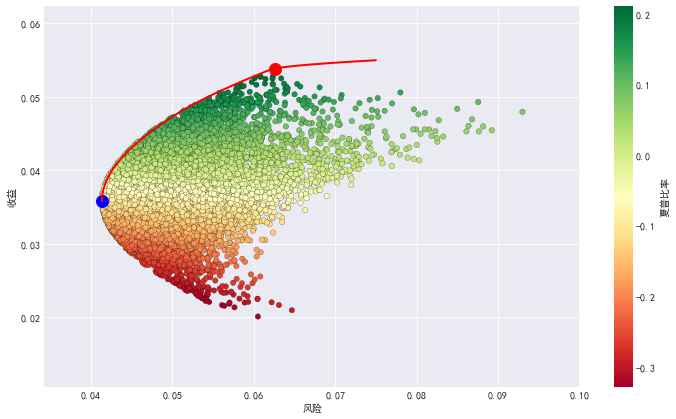

In [49]:
plt.figure(figsize=(12, 7))
plt.scatter(
    mc[:,1], mc[:,0], c=mc[:,2],cmap='RdYlGn', 
    edgecolors='black',marker='o',
    linewidth=0.2,s=30) 
plt.grid(True)
plt.xlabel('风险')
plt.ylabel('收益')
plt.colorbar(label='夏普比率')
plt.plot(*_f(mv,cov.values,exr.values),'bo',markersize=12)
plt.plot(*_f(sr,cov.values,exr.values),'ro',markersize=12)
plt.plot(
    *np.array(
        [_f(_w(V,r,i),cov.values,exr.values) 
         for i in np.linspace(_f(mv,cov.values,exr.values)[1],exr.max(),100)]
    ).T,
    'r',linewidth=2)

# 资本配置线
[CAL](https://baike.baidu.com/item/%E8%B5%84%E6%9C%AC%E9%85%8D%E7%BD%AE%E7%BA%BF/6308143?fr=aladdin),是引入无风险借贷后，将一定量的资本在某一特定的风险资产组合与无风险资产之间分配，描述所有可能的新组合的预期收益与风险之间关系的线条。

# 资本市场线
[CML](https://baike.baidu.com/item/%E8%B5%84%E6%9C%AC%E5%B8%82%E5%9C%BA%E7%BA%BF/8332395?fr=aladdin),资本市场线是指表明有效组合的期望收益率和标准差之间的一种简单的线性关系的一条射线。它是沿着投资组合的有效边界，由风险资产和无风险资产构成的投资组合。

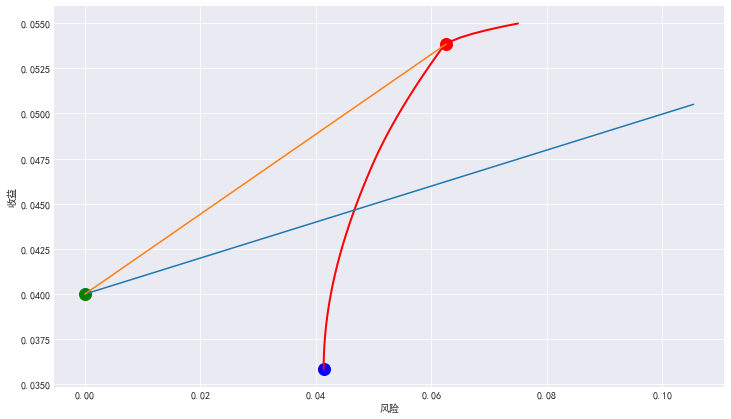

In [50]:
plt.figure(figsize=(12, 7))
plt.grid(True)
plt.xlabel('风险')
plt.ylabel('收益')
plt.plot(*_f(mv,cov.values,exr.values),'bo',markersize=12)
plt.plot(*_f(sr,cov.values,exr.values),'ro',markersize=12)
plt.plot(0,RFR,'go',markersize=12)
plt.plot(
    *np.array(
        [_f(_w(V,r,i),cov.values,exr.values) 
         for i in np.linspace(_f(mv,cov.values,exr.values)[1],exr.max(),100)]
    ).T,
    'r',linewidth=2)
_=np.zeros(s_n)
_[0]=1
plt.plot(*np.array([[0,RFR],_f(_,cov.values,exr.values)]).T)
plt.plot(*np.array([[0,RFR],_f(sr,cov.values,exr.values)]).T)

# 资本资产定价模型

## 概述
马科维茨投资组合理论：
1. 期望收益、风险及相关系数（方差协方差矩阵）需要持续且精确的估计
2. 较大的计算量

CAPM：

阐述了在投资者都采用马科维茨的理论进行投资管理的条件下市场均衡状态的形成，把资产的预期收益与预期风险之间的理论关系用一个简单的线性关系表达出来了，即认为一个资产的预期收益率与衡量该资产风险的一个尺度β值之间存在正相关关系。

$E(R_i)-R_f=\beta_i\left[E(R_m)-R_f\right]$

[（Capital Asset Pricing Model 简称CAPM）](https://wiki.mbalib.com/wiki/CAPM)

## 证明

### 构建Q+风险资产组合

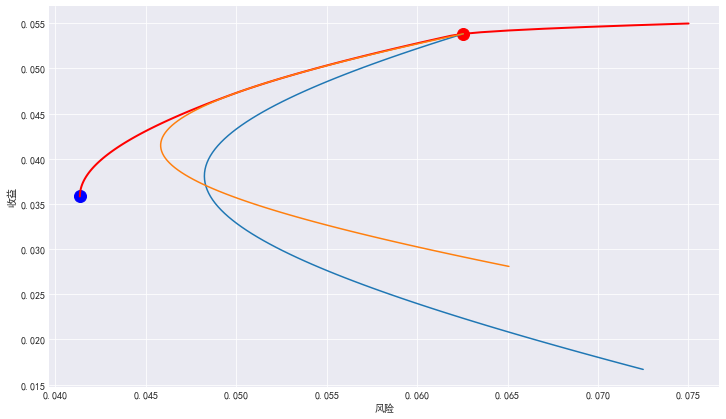

In [51]:
plt.figure(figsize=(12, 7))
plt.grid(True)
plt.xlabel('风险')
plt.ylabel('收益')
plt.plot(*_f(mv,cov.values,exr.values),'bo',markersize=12)
plt.plot(*_f(sr,cov.values,exr.values),'ro',markersize=12)
plt.plot(
    *np.array(
        [_f(_w(V,r,i),cov.values,exr.values) 
         for i in np.linspace(_f(mv,cov.values,exr.values)[1],exr.max(),100)]
    ).T,
    'r',linewidth=2)
# 第一种方案，权重配比
_i=1
_=np.zeros(s_n)
_[_i]=1
plt.plot(
    *np.array([_f(sr*i+_*(1-i),cov.values,exr.values) for i in np.linspace(0,1,100)]).T,
)
# 第二种方案，经典方法
# 求Q组合的方差。为什么这个表达式代表Q组合的风险，参看《组合风险推导》
# 求第i项资产的方差
_i=2
_c=(cov.values@sr)[_i]# 第i项资产与Q组合的协方差
_cov=np.array([[sr.T@cov.values@sr,_c],[_c,cov.values[_i,_i]]])
_exr=np.array([sr.T@exr.values,exr.values[_i]])
plt.plot(
    *np.array([_f(np.array([i,1-i]),_cov,_exr) for i in np.linspace(0,1,100)]).T,
)

**总结：**
1. 构造组合的可行集属于全市场可行集
2. 构造组合的可行集与市场有限前沿相切与Q点

## 推导

In [52]:
ui,um,uf,si,sm,sim,wi=sp.symbols('\mu_i,\mu_m,\mu_f,\sigma_i,\sigma_m,\sigma_{{im}},w_i')
ui,um,uf,si,sm,sim,wi

In [53]:
# 构造组合的期望收益
uw=wi*ui+(1-wi)*um
uw

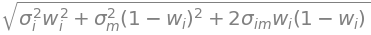

In [54]:
# 构造组合的标准差
sw=sp.sqrt(wi**2*si**2+(1-wi)**2*sm**2+2*wi*(1-wi)*sim)
sw

$\because 两者相切与Q点，和链式法则
\\\therefore\Large \frac{\partial \mu_w}{\partial \sigma_w}=\frac{\frac{\partial \mu_w}{\partial w}}{\frac{\partial \sigma_w}{\partial w}}=\frac{\mu_m-\mu_f}{\sigma_m},w=0$

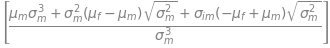

In [55]:
xx=sp.solve(sp.Eq(sp.diff(uw,wi)/sp.diff(sw,wi).subs(wi,0),(um-uf)/sm),ui)
xx

令$\beta=\frac{\sigma_{im}}{\sigma_m^2}$,上式化简可得：$\underbrace{\mu_i-\mu_f}_{风险资产超额收益}=(\mu_m-\mu_f)\frac{\sigma_{im}}{\sigma_m^2}=\beta\underbrace{(\mu_m-\mu_f)}_{市场组合超额收益}$

# 证券市场线
[SML](https://wiki.mbalib.com/wiki/SML%E7%BA%BF),是资本资产定价模型（CAPM）以$\beta$为横坐标，预期收益为纵坐标，构建的一条从无风险收益资产开始的射线。它主要用来说明投资组合预期收益与系统风险程度$\beta$系数之间的关系。

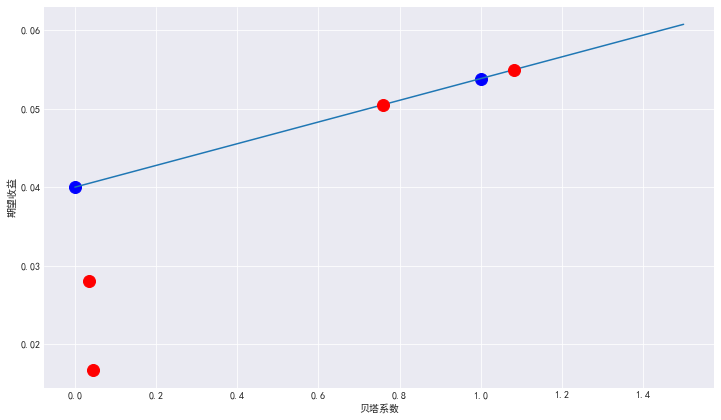

In [56]:
plt.figure(figsize=(12, 7))
plt.grid(True)
plt.xlabel('贝塔系数')
plt.ylabel('期望收益')
plt.plot(*np.array([[0,RFR],[1,sr@exr.values]]).T,'bo',markersize=12)
_umf=(sr@exr.values-RFR)
plt.plot(*np.array([[i,i*_umf+RFR] for i in np.linspace(0,1.5,3)]).T)
plt.plot(cov.values@sr/(sr.T@cov.values@sr),exr.values,'ro',markersize=12)

# 收益构成

$\underbrace{R_i}_{收益}=\underbrace{R_f}_{无风险收益}+\underbrace{\beta_i\left[R_m-R_f\right]}_{系统性风险收益}+\underbrace{\alpha_i}_{非系统性风险收益}$

# A股数据

1. 股票因子数据
2. 行业指数价格
3. 行业指数信息
4. 市场组合指数（沪深300指数）
5. 股票价格
6. 股票行业归属
7. 沪深300成分股权重表

## 加载数据

In [57]:
h5 = pd.HDFStore('data/data.h5', mode='r')  
h5.keys()

['/fac',
 '/ind_close',
 '/ind_info',
 '/inx_close',
 '/obj_close',
 '/obj_cls',
 '/obj_weight']

## 股票因子数据

In [58]:
h5['fac'].head()

,avg_turn_20,avg_turn_240,avg_turn_60,beta_csi300_60_0,close_0,date,fs_common_equity_0,fs_net_cash_flow_ttm_0,fs_net_profit_yoy_0,fs_non_current_liabilities_0,...,fs_total_liability_0,instrument,market_cap_0,market_cap_float_0,pb_lf_0,pe_ttm_0,return_60,swing_volatility_60_0,volatility_60_0,west_eps_ftm_0
0,0.361890,0.364016,0.241283,0.798543,32.895355,2019-03-04,3.696409e+10,-2.738063e+09,8.335700,2.171018e+10,...,9.037635e+10,600297.SHA,4.116363e+10,4.079482e+10,1.119917,9.966406,1.183529,0.017560,0.022313,0.5308
1,1.166124,0.571547,0.827291,0.753365,294.284088,2019-03-04,3.234399e+10,2.099414e+09,4.464700,1.699484e+10,...,5.457291e+10,600089.SHA,2.956744e+10,2.956593e+10,1.014530,12.976037,1.162044,0.009117,0.015089,0.6978
2,5.080401,3.110909,3.564228,1.324330,54.565777,2019-03-04,8.044239e+09,-1.128414e+08,74.143097,1.218728e+09,...,1.136024e+10,603799.SHA,3.196187e+10,3.158182e+10,3.973262,11.796223,1.158496,0.023050,0.030983,2.8106
3,1.151961,0.963841,0.791393,0.503264,67.877487,2019-03-04,7.306716e+09,6.637488e+08,11.567500,3.088342e+07,...,1.013928e+09,000408.SZA,2.384560e+10,5.341728e+09,3.263519,18.449429,1.050967,0.010574,0.015331,0.7142
4,3.082663,1.035434,2.424723,0.713421,109.131134,2019-03-04,2.432507e+10,5.131218e+09,-92.448303,3.669428e+10,...,7.914598e+10,600157.SHA,2.671546e+10,2.671546e+10,1.098269,120.433922,1.221591,0.034369,0.050207,0.0691


## 行业指数价格

In [59]:
h5['ind_close'].head()

,instrument,date,s_dq_close
0,801880.SI,2019-01-02,3364.27
1,801740.SI,2019-01-02,894.03
2,801210.SI,2019-01-02,4735.80
3,801200.SI,2019-01-02,2964.57
4,801750.SI,2019-01-02,3150.27


## 行业指数信息

In [61]:
h5['ind_info']

,industriesalias,industriesname,memo
356,801080.SI,电子,270000
968,801770.SI,通信,730000
1067,801040.SI,钢铁,230000
1084,801180.SI,房地产,430000
1661,801890.SI,机械设备,640000
2164,801720.SI,建筑装饰,620000
2833,801110.SI,家用电器,330000
3360,801780.SI,银行,480000
4289,801010.SI,农林牧渔,110000
4573,801200.SI,商业贸易,450000


## 市场组合指数（沪深300指数）

In [62]:
h5['inx_close'].head()

,instrument,date,s_dq_close
0,000300.SHA,2019-01-02,2969.5353
1,000300.SHA,2019-01-03,2964.8421
2,000300.SHA,2019-01-04,3035.8741
3,000300.SHA,2019-01-07,3054.3030
4,000300.SHA,2019-01-08,3047.7035


## 股票价格

In [63]:
h5['obj_close'].head()

,instrument,date,s_dq_adjclose
0,600518.SHA,2019-01-02,372.15
1,600549.SHA,2019-01-02,153.67
2,600570.SHA,2019-01-02,724.17
3,600023.SHA,2019-01-02,7.23
4,000786.SZA,2019-01-02,142.95


## 股票行业归属

In [64]:
h5['obj_cls'].head()

,date,instrument,industry_sw_level1
0,2019-03-04,600415.SHA,450000
1,2019-03-04,600299.SHA,220000
2,2019-03-04,600309.SHA,220000
3,2019-03-04,600660.SHA,280000
4,2019-03-04,600177.SHA,430000


## 沪深300成分股权重表

In [65]:
h5['obj_weight'].head()

,date,instrument,weight
401,2019-01-02,002241.SZA,0.001426
402,2019-01-02,002230.SZA,0.003842
403,2019-01-02,002179.SZA,0.001418
404,2019-01-02,002153.SZA,0.000884
405,2019-01-02,002146.SZA,0.001472


#  Beta

## 行业指数$\beta$

行业指数的收益率序列

In [86]:
ind_ret=h5['ind_close'].set_index('date').groupby('instrument').apply(lambda i:np.log(i).diff().iloc[1:,:])
ind_ret=ind_ret.unstack(0)
ind_ret.columns=ind_ret.columns.droplevel(0)

In [87]:
na(ind_ret)

In [88]:
ind_ret.head()

instrument,801010.SI,801020.SI,801030.SI,801040.SI,801050.SI,801080.SI,801110.SI,801120.SI,801130.SI,801140.SI,...,801720.SI,801730.SI,801740.SI,801750.SI,801760.SI,801770.SI,801780.SI,801790.SI,801880.SI,801890.SI
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.001376,0.000031,-0.009764,0.004839,0.010878,-0.018785,-0.005360,-0.019283,-0.008358,-0.008521,...,-0.001549,-0.001338,0.031717,-0.005181,-0.005659,-0.023717,0.008808,0.015021,-0.009563,-0.002140
2019-01-04,0.022919,0.019222,0.019993,0.016694,0.023939,0.020810,0.021326,0.018145,0.018216,0.020109,...,0.022616,0.030395,0.023771,0.038957,0.029046,0.018404,0.020393,0.042590,0.015538,0.024149
2019-01-07,0.023130,0.014805,0.014974,0.013634,0.018326,0.028248,0.004181,0.008772,0.013107,0.013747,...,0.012573,0.032052,0.042510,0.027252,0.016918,0.031417,-0.002179,-0.003469,0.014377,0.023132
2019-01-08,-0.007305,0.000606,0.000957,-0.002930,-0.013494,0.004085,0.001549,-0.003738,0.002463,-0.001010,...,0.000078,-0.000880,-0.018743,-0.005174,0.000602,-0.005516,-0.004347,-0.003220,-0.001600,0.001473
2019-01-09,-0.000361,0.001533,0.008862,0.007602,0.000267,0.007476,0.038257,0.015079,0.005175,0.006200,...,-0.001771,0.002945,-0.010679,-0.000390,0.002250,0.005068,0.008510,0.009539,0.017082,-0.001849


市场组合的收益率序列

In [80]:
inx_ret=np.log(h5['inx_close'].set_index('date').s_dq_close).diff().iloc[1:]

In [83]:
na(ind_ret)

In [81]:
inx_ret.head()

date
2019-01-03   -0.001582
2019-01-04    0.023676
2019-01-07    0.006052
2019-01-08   -0.002163
2019-01-09    0.010046
Name: s_dq_close, dtype: float64

检查行数是否一致

In [82]:
ind_ret.shape,inx_ret.shape

合并行业和市场的收益率序列

In [90]:
x=ind_ret.merge(right=inx_ret,left_index=True,right_index=True,how='outer')

计算各资产与市场组合的协方差

$\beta=\frac{cov(s,m)}{\sigma_m^2}=\frac{\rho\sigma_s}{\sigma_m}$

In [93]:
b,m=x.corrwith(x.iloc[:,-1])*x.std()/x.iloc[:,-1].std(),x.mean()*YTD

In [102]:
b.index

Index(['801010.SI', '801020.SI', '801030.SI', '801040.SI', '801050.SI',
       '801080.SI', '801110.SI', '801120.SI', '801130.SI', '801140.SI',
       '801150.SI', '801160.SI', '801170.SI', '801180.SI', '801200.SI',
       '801210.SI', '801230.SI', '801710.SI', '801720.SI', '801730.SI',
       '801740.SI', '801750.SI', '801760.SI', '801770.SI', '801780.SI',
       '801790.SI', '801880.SI', '801890.SI', 's_dq_close'],
      dtype='object')

In [103]:
_kv={i[0]:i[1] for i in h5['ind_info'].values}
_kv['s_dq_close']='市场组合'

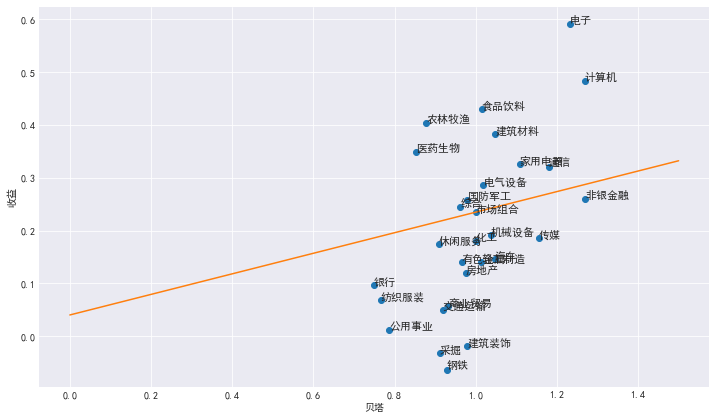

In [114]:
plt.figure(figsize=(12, 7))
plt.grid(True)
plt.xlabel('贝塔')
plt.ylabel('收益')
plt.plot(b,m,'o')
_=list(map(lambda x:plt.text(*x,fontsize=11),zip(b,m,[_kv[i] for i in b.index])))
plt.plot(*np.array([[i,i*(x.iloc[:,-1].mean()*YTD-RFR)+RFR] for i in np.linspace(0,1.5,3)]).T)

# 运用
1. 已知风险，求收益
2. 已知收益，求风险，引出APT

# 套利定价模型（APT Arbitrage Pricing Theory ）

# 风险

# BARRA

1. 求市值权重、风险平价权重、最大因子暴漏（可投资性和因子性）等配置的barra风险